<h1><b>Text Generation for</b>
<b>Mathematical Problems</b></h1>


In the following notebook, methods of generating textual mathematical problems are explored.

This will be achieved by applying several different Deep Learning generative text models to the [DeepMind Mathematics Dataset](https://github.com/deepmind/mathematics_dataset).


This dataset contains questions-answer pairs for a multitude of different topics eg. calculus, probability, algebra. Files are seperated by topic. Example questions are shown below.




```
Question: Solve -42*r + 27*c = -1167 and 130*r + 4*c = 372 for r.
Answer: 4

Question: Calculate -841880142.544 + 411127.
Answer: -841469015.544

Question: Let x(g) = 9*g + 1. Let q(c) = 2*c + 1. Let f(i) = 3*i - 39. Let w(j) = q(x(j)). Calculate f(w(a)).
Answer: 54*a - 30

Question: Let e(l) = l - 6. Is 2 a factor of both e(9) and 2?
Answer: False
```






# **1. Model 1: Simple RNN for calculus questions**

First, using a simple RNN model, we will try to generate some text on a character level, by training on a single file of our choice.

## Importing modules and the data
Performing required imports, mounting Google Drive and checking for GPU. For training, sample dataset must be downloaded from the mathematics dataset Github and put into Google Drive.

Make sure that the GPU is enabled in the Google Colab settings (`Edit -> Notebook Settings -> Hardware accelerator -> GPU`)



In [1]:
import tensorflow as tf
import numpy as np
import random
import os
from google.colab import drive

device_name = tf.test.gpu_device_name()
print('Found GPU at: {}'.format(device_name))

print(tf.__version__)

drive.mount('/content/gdrive', force_remount=True)

Found GPU at: /device:GPU:0
2.8.0
Mounted at /content/gdrive


In [2]:
# Load data from mathematics dataset. Text files are formatted in
# pairs of Question-Answer and so the line with the answer is ommitted

training_folder = "train-hard"  # @param {type: "string"}
training_file = "calculus__differentiate_composed.txt"  # @param {type: "string"}

training_file_path = '/content/gdrive/MyDrive/CCProject/mathematics_dataset-v1.0 2/'+training_folder+'/'+training_file

#text = open(training_file_path, 'rb').read().decode(encoding='utf-8')

text = open(training_file_path, encoding='utf-8').readlines()[::2] 

text = (''.join(text))

In [3]:
# Testing our text length
print(len(text))
print(type(text))
print(text[0:300])

80394849
<class 'str'>
What is the derivative of -92 + 7238*g**2 - 3619*g**2 + 3*g + 15*g**4 - 3621*g**2 - 3*g wrt g?
Let d(o) = 6015*o - 9339. Let b(j) = 859*j - 1334. Let c(n) = -27*b(n) + 4*d(n). Find the first derivative of c(q) wrt q.
Let r(y) be the second derivative of 787*y**4/4 - 168*y**2 - 1718*y. What is the de


## Vectorising the text and creating the inputs and targets

Next, we must create dictionaries mapping each unique character to an index an another dictionary to be able to invert this operation. These are used to create input and target dataset for our model.

In [4]:
def process_text(text):
    vocabulary = sorted(set(text))  # The list of unique characters in the file
    # Creating a mapping each unique character to an index and vice versa
    char2idx = {value:key for key, value in enumerate(vocabulary)}
    idx2char = {value:key for key, value in char2idx.items()}
    text_as_int = np.array([char2idx[c] for c in text]) # Text translated to indices
    return text_as_int, vocabulary, char2idx, idx2char

def split_batches(batch):
    # Target text is the input text sliding along one character eg. Input: "operatio" Target: "peration"
    input_text, target_text = batch[:-1], batch[1:]
    return input_text, target_text

# Create the batched dataset
def define_dataset(text_as_int, max_length, batch_size, buffer_size):
    char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)
    dataset = char_dataset.batch(max_length + 1, drop_remainder=True).map(split_batches)
    dataset = dataset.shuffle(buffer_size).batch(batch_size, drop_remainder=True)
    return dataset

In [5]:
text_as_int, vocabulary, char2idx, idx2char = process_text(text)

dataset = define_dataset(text_as_int, max_length=100, batch_size=512, buffer_size=10000)

In [6]:
print(vocabulary)
print(text_as_int)
print(char2idx)

print((dataset))

['\n', ' ', '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '=', '?', 'D', 'F', 'L', 'S', 'W', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
[26 34 27 ... 45  8  0]
{'\n': 0, ' ': 1, '(': 2, ')': 3, '*': 4, '+': 5, ',': 6, '-': 7, '.': 8, '/': 9, '0': 10, '1': 11, '2': 12, '3': 13, '4': 14, '5': 15, '6': 16, '7': 17, '8': 18, '9': 19, '=': 20, '?': 21, 'D': 22, 'F': 23, 'L': 24, 'S': 25, 'W': 26, 'a': 27, 'b': 28, 'c': 29, 'd': 30, 'e': 31, 'f': 32, 'g': 33, 'h': 34, 'i': 35, 'j': 36, 'k': 37, 'l': 38, 'm': 39, 'n': 40, 'o': 41, 'p': 42, 'q': 43, 'r': 44, 's': 45, 't': 46, 'u': 47, 'v': 48, 'w': 49, 'x': 50, 'y': 51, 'z': 52}
<BatchDataset element_spec=(TensorSpec(shape=(512, 100), dtype=tf.int64, name=None), TensorSpec(shape=(512, 100), dtype=tf.int64, name=None))>


## Defining and training our model

Next, we can define our RNN model that will be used to generate text and that we will train with the dataset we have created.

In [6]:
# Define loss function
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

def build_model(vocab_size=len(vocabulary), embedding_dim=256, rnn_units=1024, batch_size=512):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim, batch_input_shape=[batch_size, None]),
        tf.keras.layers.SimpleRNN(rnn_units, return_sequences=True, stateful=True, recurrent_initializer='glorot_uniform'),
        tf.keras.layers.Dense(vocab_size)
    ])
    return model

In [7]:
model = build_model()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer, loss=loss)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (512, None, 256)          13568     
                                                                 
 simple_rnn (SimpleRNN)      (512, None, 1024)         1311744   
                                                                 
 dense (Dense)               (512, None, 53)           54325     
                                                                 
Total params: 1,379,637
Trainable params: 1,379,637
Non-trainable params: 0
_________________________________________________________________


In [8]:
history = model.fit(dataset, epochs=2)
model.save_weights("gen_text_weights.h5", save_format='h5')
# To keep this prediction step simple, use a batch size of 1
gen_model = build_model(vocab_size=len(vocabulary), batch_size=1)
gen_model.load_weights("gen_text_weights.h5")
gen_model.summary()

Epoch 1/2
1554/1554 [==============================] - 281s 179ms/step - loss: 0.9297
Epoch 2/2
1554/1554 [==============================] - 269s 173ms/step - loss: 0.7537
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (1, None, 256)            13568     
                                                                 
 simple_rnn_1 (SimpleRNN)    (1, None, 1024)           1311744   
                                                                 
 dense_1 (Dense)             (1, None, 53)             54325     
                                                                 
Total params: 1,379,637
Trainable params: 1,379,637
Non-trainable params: 0
_________________________________________________________________


## Generating text

Now that we have trained our model we can define a new model of batch size 1 with the same weights, to generate text data given a prompt.

In [9]:
def generate_text(model, start_string, generate_char_num=1000, char2idx=char2idx, idx2char=idx2char):
    # First, vectorise the input to the function
    input_eval = [char2idx[s] for s in start_string]
    input_eval = tf.expand_dims(input_eval, 0)


    text_generated = []  # Empty string to store our results

    model.reset_states()
    for i in range(generate_char_num):
        predictions = model(input_eval)
        predictions = tf.squeeze(predictions, 0)  # remove the batch dimension

        # using a categorical distribution to predict the character returned by the model
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1, 0].numpy()

        # We pass the predicted character as the next input to the model along with the previous hidden state
        input_eval = tf.expand_dims([predicted_id], axis=0)
        text_generated.append(idx2char[predicted_id])

    return start_string + ''.join(text_generated)

In [34]:
# Generation of our text!

input_text = "L"  #@param {type: "string"}
n_characters_output = 1000#@param 
generated_text = generate_text(gen_model, start_string=input_text, generate_char_num=n_characters_output)
print(generated_text)

Let y be l(-1). Let m(o) wrt o.
Suppose -18*w + 44 - 404 = -3*x + 3*p, x = b - 196. Let k be 8 + (t + (-52)/6). Let w be (-12 + 5)*(110/(-686)) - 2918/9. What is the first derivative of 2*a**4 - 8*a - 1906*a**f + 0*a**5 wrt a.
Find the second derivative of 633*i**3 + 117947*i + 6152*i**6 wrt i.
Differentiate -1827 + 1388*r**2 - 548 - 186369 - 31216*r - 1524*r + 41801 wrt r.
Let w(w) be the third derivative of -53*w**6/40 + 197*w**3/6 - 4*w**2 - 68*w. What is the second derivative of n(m) wrt m?
Differentiate -2240727*j**3 - 1856978589 - 187099 + 8897 + 791787*j - 95 wrt j.
Let a(l) be the first derivative of -969*l**4/4 + 2455*l + 1470. Differentiate x(b) with respect to b.
What is the third derivative of 17*f t.
Suppose y - 137 = 14*d - 2*h, 3*w = 0 + 5. Find the second derivative of -2 tive of p(o) wrt o.
Let q(b) be the third derivative of 871697*b**8/53 + b**5/20 + b**4/12 - 4*b**3 + 5*b**2 + 3*b - 14. What is the first derivative of h(k) wrt k?
Let z(d) be the third derivative of 

In [41]:
question_list = generated_text.split("\n")

print(question_list[0])
print(question_list[1])
print(question_list[2])

Let y be l(-1). Let m(o) wrt o.
Suppose -18*w + 44 - 404 = -3*x + 3*p, x = b - 196. Let k be 8 + (t + (-52)/6). Let w be (-12 + 5)*(110/(-686)) - 2918/9. What is the first derivative of 2*a**4 - 8*a - 1906*a**f + 0*a**5 wrt a.
Find the second derivative of 633*i**3 + 117947*i + 6152*i**6 wrt i.


The questions generated display encouraging results. Some questions produced make sense sequentially (expression given and then task to be completed stated) and the mathematical equations are almost always differentiable. This gives the appearance that the questions make sense at first glance but with a closer look most of the questions are not solvable. 

The main problem that occurs is the one seen in the following question


```
Let a(l) be the first derivative of -969*l**4/4 + 2455*l + 1470. Differentiate x(b) with respect to b.
```

Both parts of the question make sense on their own. The first states an equation a(l) and the second part asks you to differentiate x(b) with respect to b. However, when putting the two together, the question becomes unsolvable. 

Despite this, some questions like the following are not only solvable but do not appear in the original dataset and so are completely new questions!


```
Find the second derivative of 633*i**3 + 117947*i + 6152*i**6 wrt i.

Differentiate -1827 + 1388*r**2 - 548 - 186369 - 31216*r - 1524*r + 41801 wrt r.
```

# **2. Investigation of RNN model for different topics**

In the previous section we saw that the model struggles with longer questions, seemingly forgetting what the equation concering us consisted of, resulting in questions that do not make sense as a whole. 

In this section, the model will be tested with questions in different topics to gain insight into what it does well and where it fails.

## Questions on conversion of units


In [31]:
#Load data

training_folder = "train-hard"  # @param {type: "string"}
training_file = "measurement__conversion.txt"  # @param {type: "string"}
training_file_path = '/content/gdrive/MyDrive/CCProject/mathematics_dataset-v1.0 2/'+training_folder+'/'+training_file

text1 = open(training_file_path, encoding='utf-8').readlines()[::2] 
text1 = (''.join(text1))

# Create vectorised dataset
text_as_int1, vocabulary1, char2idx1, idx2char1 = process_text(text1)
dataset1 = define_dataset(text_as_int1, max_length=100, batch_size=512, buffer_size=10000)

#Compile model
model1 = build_model(vocab_size=len(vocabulary1))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model1.compile(optimizer, loss=loss)


#Train model
history1 = model1.fit(dataset1, epochs=2)
model1.save_weights("gen_text_weights1.h5", save_format='h5')
gen_model1 = build_model(vocab_size=len(vocabulary1), batch_size=1)
gen_model1.load_weights("gen_text_weights1.h5")


# Generate questions
input_text = "W"  #@param {type: "string"}
n_characters_output = 1000#@param 
generated_text1 = generate_text(gen_model1, start_string=input_text, generate_char_num=n_characters_output, char2idx=char2idx1, idx2char=idx2char1)
print(generated_text1)

Epoch 1/2
580/580 [==============================] - 109s 168ms/step - loss: 0.7808
Epoch 2/2
580/580 [==============================] - 99s 168ms/step - loss: 0.4783
What is 45665.83 litres in illilitres?
What is 0.0378906 centuries to decades.
Convert 51.79456 centimeters to meters.
Convert 671.4646 centuries to months.
What is 13/3 of a kilogram in grams?
How many nanoseconds are there in 8250.019ns?
What is 559.8863 nanoseconds in hours?
What is 1/4 of a millimeter?
How many millilitres are there in seventy-nine fifths of a litre?
What is 0.698131 tonnes in milligrams?
How many decades are there in twenty-nine f anvert 4362.372 millennia to decades.
What is 14.6365t in micrograms?
What is four thirds of a litre in millilitres?
What is 5/4 of a milligram in micrograms?
How many seconds are there in 45/4 of a week?
How many months are there in 0.5404472 millennia?
How many millilitres are there in 25/4 of a litre?
Convert 17241.157 weeks to daysHow many millilitres are there in 11/5 

As we can see the questions produced are of quite good value. They almost always have units that coincide with each other (nanoseconds-hours, centimeters-meters etc) and make sense gramatically. The questions are generally small and so we may not be encountering the problem of "forgetting" the earlier part of the question.

## Questions on Greatest Common Divisor

In [33]:
#Load data

training_folder = "train-hard"  # @param {type: "string"}
training_file = "numbers__gcd_composed.txt"  # @param {type: "string"}
training_file_path = '/content/gdrive/MyDrive/CCProject/mathematics_dataset-v1.0 2/'+training_folder+'/'+training_file

text2 = open(training_file_path, encoding='utf-8').readlines()[::2] 
text2 = (''.join(text2))

# Create vectorised dataset
text_as_int2, vocabulary2, char2idx2, idx2char2 = process_text(text2)
dataset2 = define_dataset(text_as_int2, max_length=100, batch_size=512, buffer_size=10000)

#Compile model
model2 = build_model(vocab_size=len(vocabulary2))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model2.compile(optimizer, loss=loss)
 

#Train model
history2 = model2.fit(dataset2, epochs=2)
model2.save_weights("gen_text_weights2.h5", save_format='h5')
gen_model2 = build_model(vocab_size=len(vocabulary2), batch_size=1)
gen_model2.load_weights("gen_text_weights2.h5")


# Generate questions
input_text = "W"  #@param {type: "string"}
n_characters_output = 1000#@param 
generated_text2 = generate_text(gen_model2, start_string=input_text, generate_char_num=n_characters_output, char2idx=char2idx2, idx2char=idx2char2)
print(generated_text2)

Epoch 1/2
1446/1446 [==============================] - 244s 167ms/step - loss: 0.9501
Epoch 2/2
1446/1446 [==============================] - 243s 168ms/step - loss: 0.7552
What is the highest common divisor of d and 273?
Suppose 5*u - 2021 = 2*m, 2*u - 2*f = -2*u = -175 + 226. What is the greatest common divisor of m and 49?
Let u be -5 + -2 - -1 + -1. Let j be 17/((-75)/(-9)). What is the highest common factor of 26160 and c?
Let m be 1 - 0 - (142/(-54)*-90)/((-2)/(-165))). Calculate the highest common factor of h and 20.
Let u(q) = -26 s = 3*u. What is the highest common factor of s and x?
Suppose -5*o + 4*t = 4*f - 255, -3*x - 951 = -5*a. Calculate the greatest common factor of q and 2298.
Let w be 6 1*v + 96, 4*l - 12*o + 923 = 25*f. Suppose 35*s = 3*s - 140. What is the greatest common divisor of 273 and i?
Suppose 9*l - 4230 = 10156. Calculate the greatest common divisor of a and f.
Suppose h - 32 = 9. Suppose -5*b + 4*o + j = 0. Calculate the greatest common factor of 1000 and g

These questions are in general more complicated and the model fails to produce quality questions, obviously mixing variables together. 

## Questions on Linear Algebra

Here 2 versions of questions on linear algebra are produced. As we can see the simpler version of the questions produce great original solvable questions but that cannot be said for the more complicated questions with more information.

In [14]:
#Load data

training_folder = "train-hard"  # @param {type: "string"}
training_file = "algebra__linear_1d_composed.txt"  # @param {type: "string"}
training_file_path = '/content/gdrive/MyDrive/CCProject/mathematics_dataset-v1.0 2/'+training_folder+'/'+training_file

text3 = open(training_file_path, encoding='utf-8').readlines()[::2] 
text3 = (''.join(text3))

# Create vectorised dataset
text_as_int3, vocabulary3, char2idx3, idx2char3 = process_text(text3)
dataset3 = define_dataset(text_as_int3, max_length=100, batch_size=512, buffer_size=10000)

#Compile model
model3 = build_model(vocab_size=len(vocabulary3))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model3.compile(optimizer, loss=loss)
 

#Train model
history3 = model3.fit(dataset3, epochs=2)
model3.save_weights("gen_text_weights3.h5", save_format='h5')
gen_model3 = build_model(vocab_size=len(vocabulary3), batch_size=1)
gen_model3.load_weights("gen_text_weights3.h5")


# Generate questions
input_text = "S"  #@param {type: "string"}
n_characters_output = 1000#@param 
generated_text3 = generate_text(gen_model3, start_string=input_text, generate_char_num=n_characters_output, char2idx=char2idx3, idx2char=idx2char3)
print(generated_text3)

Epoch 1/2
1212/1212 [==============================] - 260s 213ms/step - loss: 1.1832
Epoch 2/2
1212/1212 [==============================] - 262s 215ms/step - loss: 0.9736
Suppose 5*h - 130 = 7*h. Let p(g) = -2*g - 8. Let u be r(g). Suppose -4*n = 8*t - 16. Suppose 5*x = a + 27. Let m = -2 + h. Solve m*s + 41*s = r for s.
Suppose 4*h - 3 + 36 = 06. Let h(d) = d**2 - 12*d - 23. Let d be w(1). Suppose 13*k - l = 10*k - 76. Solve -4*a = -s - y for a.
Suppose -5*d - 123 = 4*q + 29, -2*i = i - 13. Suppose 3*a = 15 - 7. Solve d*d - s = 2 for d.
Let u = 49 - -12. Let v = 30 - h. Solve v + 1 = -l for v.
Let j be (12 - 253) + 2 + -3. Solve c*d + 6 = 29*d for d.
Let y(m) = -1822 - 14501. Let i be p(12). Solve u*q = 145*q - 40 for q.
Let x be ((-8)/5)/(-1*(-48)/(-44). Suppose 0 = c*v + 45 - 48. Solve -v = -l - 5*c for c.
Suppose 4*p = -t 10. Suppose 11*b = -v - 92. Solve -25*w = -w*w + 606 for w.
Let o be ((-6)/(-16))/(4/10). Let y be 2 + z = -46 + j. Let k be (-22)/17 - 6/x. Solve + 11 = 5*f. So

In [17]:
#Load data

training_folder = "train-hard"  # @param {type: "string"}
training_file = "algebra__linear_1d.txt"  # @param {type: "string"}
training_file_path = '/content/gdrive/MyDrive/CCProject/mathematics_dataset-v1.0 2/'+training_folder+'/'+training_file

text4 = open(training_file_path, encoding='utf-8').readlines()[::2] 
text4 = (''.join(text4))

# Create vectorised dataset
text_as_int4, vocabulary4, char2idx4, idx2char4 = process_text(text4)
dataset4 = define_dataset(text_as_int4, max_length=100, batch_size=512, buffer_size=10000)

#Compile model
model4 = build_model(vocab_size=len(vocabulary4))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model4.compile(optimizer, loss=loss)
 

#Train model
history4 = model4.fit(dataset4, epochs=2)
model4.save_weights("gen_text_weights4.h5", save_format='h5')
gen_model4 = build_model(vocab_size=len(vocabulary4), batch_size=1)
gen_model4.load_weights("gen_text_weights4.h5")


# Generate questions
input_text = "S"  #@param {type: "string"}
n_characters_output = 1000#@param 
generated_text4 = generate_text(gen_model4, start_string=input_text, generate_char_num=n_characters_output, char2idx=char2idx4, idx2char=idx2char4)
print(generated_text4)

Epoch 1/2
558/558 [==============================] - 121s 213ms/step - loss: 1.4334
Epoch 2/2
558/558 [==============================] - 127s 226ms/step - loss: 1.1974
Solve -4391 = 395*v - 34 for v.
Solve 170*w + 40*w + 28*w + 50*w - 115415 = 0 for w.
Solve 17191 = 1842*v - 424*v + 383*v - 1505 for v.
Solve -12861*z + 90800 = -3254*z - 3647 for z.
Solve -101 - 1597 - 128 + 158 = 0 for w.
Solve -7492*j = 2348*j - 1611*j + 720 for j.
Solve 371*j + 415*j + 23289 = 12787 - 5538 for j.
Solve 21621*w - 2238 = -83689*w for w.
Solve -200*o + 892*o + 1459 - 83668 = 0 for b.
Solve -1270*a - 23977 = -992*a for a.
Solve -55455 = 154*w + 82*w for w.
Solve -645*o + 5133 - 1993 = 0 for o.
Solve 9536*z - 837003 = 68*f j - 17*j + 5432 = 10*j - 429*j for r.
Solve -230 - 313222 = -680*f for f.
Solve 0 = -129198 + 185060 for f.
Solve 059223 = -160*w - 208163 for w.
Solve 3118*z + 128*z = -196*z - 130*z + 21*z - 238*z - 36409 - 4557 = -462*j for j.
Solve 75*m - 127716 = -119512 for m.
Solve 70*y - 28137 -

## **Questions on Probability**

In [9]:
#Load data

training_folder = "train-hard"  # @param {type: "string"}
training_file = "probability__swr_p_level_set.txt"  # @param {type: "string"}
training_file_path = '/content/gdrive/MyDrive/CCProject/mathematics_dataset-v1.0 2/'+training_folder+'/'+training_file

text3 = open(training_file_path, encoding='utf-8').readlines()[::2] 
text3 = (''.join(text3))

# Create vectorised dataset
text_as_int3, vocabulary3, char2idx3, idx2char3 = process_text(text3)
dataset3 = define_dataset(text_as_int3, max_length=100, batch_size=512, buffer_size=10000)

#Compile model
model3 = build_model(vocab_size=len(vocabulary3))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model3.compile(optimizer, loss=loss)
 

#Train model
history3 = model3.fit(dataset3, epochs=3)
model3.save_weights("gen_text_weights3.h5", save_format='h5')
gen_model3 = build_model(vocab_size=len(vocabulary3), batch_size=1)
gen_model3.load_weights("gen_text_weights3.h5")


# Generate questions
input_text = "W"  #@param {type: "string"}
n_characters_output = 1000#@param 
generated_text3 = generate_text(gen_model3, start_string=input_text, generate_char_num=n_characters_output, char2idx=char2idx3, idx2char=idx2char3)
print(generated_text3)

Epoch 1/3
1316/1316 [==============================] - 225s 170ms/step - loss: 0.5827
Epoch 2/3
1316/1316 [==============================] - 225s 170ms/step - loss: 0.4155
Epoch 3/3
1316/1316 [==============================] - 224s 170ms/step - loss: 0.4067
What is prob of picking 1 z and 1 l?
What is prob of picking 1 n, 2 l, and 1 j?
Three letters picked without replacement from kqjvkjqqjkvjq. What is prob of picking 1 v, 1 w, and 1 x?
Calculate prob of picking 3 d and 1 x when four letters picked without replacement from egcgyf.
What is prob of picking 2 x when two letters picked without replacement from {z: 1, c: 1, x: 2}.
Three letters picked without replacement from {d: 2, w: 6, f: 4, x: 1}.
Three letters picked without replacement from {i: 1, q: 1, z: 2, v: 1, z: 1, g: 1}.
Calculate prob of picking 4 g when four letters picked without replacement from {n: 6, v: 1, c: 1, a: 2, d: 3}.
Four letters picked without replacement from {w: 3, u: 12}?
What is prob of picking 2 z and 2 p w

# **3. Model 2: LSTM models**

To try to mitigate the effect that long questions have on our generated problems a new model is proposed. This model employs the LSTM architecture. In this network, a memory cell is added, that can help our model keep track of long term dependancies and hopefully improve the resulting problems.

## Defining our LSTM model

In [10]:
def build_LSTM_model(vocab_size=len(vocabulary), embedding_dim=256, rnn_units=256, batch_size=512):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim,
                              batch_input_shape=[batch_size, None]),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(rnn_units,
                        return_sequences=True,
                        stateful=True,
                        recurrent_initializer='glorot_uniform'),
        tf.keras.layers.Dropout(0.2), 
        tf.keras.layers.LSTM(rnn_units,
                        return_sequences=True,
                        stateful=True,
                        recurrent_initializer='glorot_uniform'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(vocab_size)
    ])
    return model

In [11]:
#Load data

training_folder = "train-hard"  # @param {type: "string"}
training_file = "algebra__linear_1d_composed.txt"  # @param {type: "string"}
training_file_path = '/content/gdrive/MyDrive/CCProject/mathematics_dataset-v1.0 2/'+training_folder+'/'+training_file

text5 = open(training_file_path, encoding='utf-8').readlines()[::2] 
text5 = (''.join(text5))

# Create vectorised dataset
text_as_int5, vocabulary5, char2idx5, idx2char5 = process_text(text5)
dataset5 = define_dataset(text_as_int5, max_length=100, batch_size=512, buffer_size=10000)

#Compile model
model5 = build_LSTM_model(vocab_size=len(vocabulary5))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
model5.compile(optimizer, loss=loss)

#Train model
history5 = model5.fit(dataset5, epochs=15)
model5.save_weights("gen_text_weights5.h5", save_format='h5')
gen_model5 = build_LSTM_model(vocab_size=len(vocabulary5), batch_size=1)
gen_model5.load_weights("gen_text_weights5.h5")


# Generate questions
input_text = "S"  #@param {type: "string"}
n_characters_output = 1000 #@param 
generated_text5 = generate_text(gen_model5, start_string=input_text, generate_char_num=n_characters_output, char2idx=char2idx5, idx2char=idx2char5)
print(generated_text5)

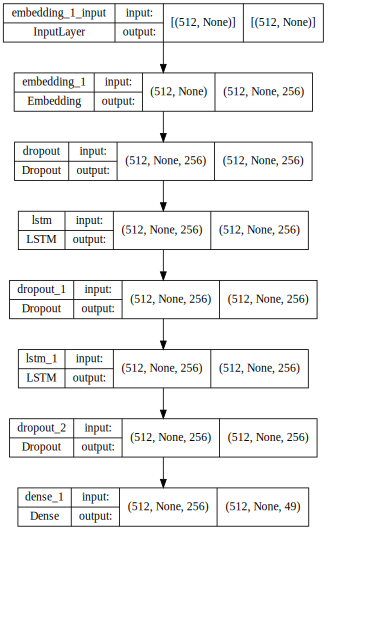

In [12]:
from IPython.display import SVG
from keras.utils import vis_utils
SVG(vis_utils.model_to_dot(model5, show_shapes=True, show_layer_names=True, dpi=60).create(prog='dot', format='svg')) 

The memory capabilities of the LSTM seem to not have an effect on remembering the variable name during a sentence.

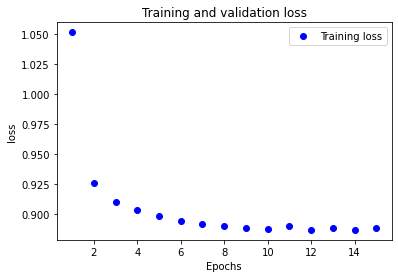

In [9]:
import matplotlib.pyplot as plt

history_dict = history5.history

#acc = history_dict['acc']
#val_acc = history_dict['val_acc']
loss = history_dict['loss']
#val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()

plt.show()

# **4. Multiple Topics with a Singular Generator**

Next, the posibility of creating a model that has freedom to generate questions on whatever topic it wants is investigated.

## Merging datasets

First, multiple different topic files must be merged into one for training the generator.

In [9]:
# Load data from mathematics dataset. Text files are formatted in
# pairs of Question-Answer and so the line with the answer is ommitted

# FIRST TOPIC

training_folder1 = "train-hard"  # @param {type: "string"}
training_file1 = "measurement__conversion.txt"  # @param {type: "string"}
training_file_path1 = '/content/gdrive/MyDrive/CCProject/mathematics_dataset-v1.0 2/'+training_folder1+'/'+training_file1
text1 = open(training_file_path1, encoding='utf-8').readlines()[::2] 
text1 = (''.join(text1))

# SECOND TOPIC
training_folder2 = "train-hard"  # @param {type: "string"}
training_file2 = "algebra__linear_1d.txt"  # @param {type: "string"}
training_file_path2 = '/content/gdrive/MyDrive/CCProject/mathematics_dataset-v1.0 2/'+training_folder2+'/'+training_file2
text2 = open(training_file_path2, encoding='utf-8').readlines()[::2] 
text2 = (''.join(text2))


# Testing our text length
print(len(text1))
print(len(text2))
print(type(text))
print(text1[0:500])

# Adding both data sets together

combined_text = text1 + text2
print(len(combined_text))

29999472
28877367
<class 'str'>
What is 3/5 of a millimeter in micrometers?
What is 2/21 of a week in seconds?
What is 88937.07ms in minutes?
What is 992214.1 decades in centuries?
How many years are there in 3647.718 decades?
What is 57/2 of a minute in seconds?
Convert 0.2732285ms to microseconds.
What is 1/5 of a kilometer in centimeters?
What is 51/5 of a milligram in micrograms?
What is 0.0693128 millilitres in litres?
How many minutes are there in 83934.55 weeks?
How many days are there in ten sevenths of a week?
How man
58876839
.
Solve 0 = 43*b + 63224 + 63892 - 128965 for b.



In [11]:
print(combined_text[58876790:58876839])
print(combined_text[0:100])

.
Solve 0 = 43*b + 63224 + 63892 - 128965 for b.

What is 3/5 of a millimeter in micrometers?
What is 2/21 of a week in seconds?
What is 88937.07ms in


## Training the Generator

The generator is trained using the RNN model proposed in Section 1.

In [ ]:
# Create vectorised dataset
text_as_int7, vocabulary7, char2idx7, idx2char7 = process_text(combined_text)
dataset7 = define_dataset(text_as_int7, max_length=100, batch_size=64, buffer_size=600000)

#Compile model
model7 = build_model(vocab_size=len(vocabulary7), batch_size=64)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model7.compile(optimizer, loss=loss)


#Train model
history7 = model7.fit(dataset7, epochs=1)
model7.save_weights("gen_text_weights7.h5", save_format='h5')
gen_model7 = build_model(vocab_size=len(vocabulary7), batch_size=1)
gen_model7.load_weights("gen_text_weights7.h5")

In [19]:
generated_text10 = generate_text(gen_model7, start_string="S", generate_char_num=n_characters_output, char2idx=char2idx7, idx2char=idx2char7)
print(generated_text10)

Solve 841*r + 39938 + 17849 = -599*r - 29372 for r.
Solve 1435*d = -729*d - 390 for d.
Solve -17681*l = -12997*l for l.
Solve -2229*r = 192*r - 18592 + 19538 for r.
Solve -5156377 = 54*k + 8641022 for k.
Solve 2733*f + 2350*f - 4693*f + 7584*f = -63686 for f.
Solve -59*h + 49288 + 14514 = 0 for h.
Solve -50*f + 865521 + 1509313 + 31640 for f.
Solve -439*a + 1487 - 33776 = in seconds?
How many milliseconds are there in 1/4 of a minute?
Convert 9870.467 kilometers in meters?
Convert 6782.518 years to months.
How many minutes are there in fourty-two fifths of a week?
How many centimeters are there in fifteen halves of a gram?
What is 57/2 of a kilogram in grams?
How many weeks are there in 982.5616 minutes?
Convert 87.56705 milligrams to millimeters.
How many months are there in 17/4 of a century?
What is twenty-three sixths of a hour in minutes?
How many nanoseconds are there in 3/5 of a week?
How many years are there in 23/4 of a decade?
How many centuries are there in 0.93033 years?
Wh

The model seems to be able to generate both linear algebra and unit conversion questions but it seems to do it in batches with the middle question separating the batches being a fusion of both topics. In this case the problem in question is: 


```
Solve -439*a + 1487 - 33776 = in seconds?
```
This could perhaps be because each batch in training contains only one topics questions. Next, we attempt to mix the type of questions in each batch.


In [29]:
# Load data from mathematics dataset. Text files are formatted in
# pairs of Question-Answer and so the line with the answer is ommitted

# FIRST TOPIC

training_folder1 = "train-hard"  # @param {type: "string"}
training_file1 = "measurement__conversion.txt"  # @param {type: "string"}
training_file_path1 = '/content/gdrive/MyDrive/CCProject/mathematics_dataset-v1.0 2/'+training_folder1+'/'+training_file1
text1 = open(training_file_path1, encoding='utf-8').readlines()[::2] 


# SECOND TOPIC
training_folder2 = "train-hard"  # @param {type: "string"}
training_file2 = "algebra__linear_1d.txt"  # @param {type: "string"}
training_file_path2 = '/content/gdrive/MyDrive/CCProject/mathematics_dataset-v1.0 2/'+training_folder2+'/'+training_file2
text2 = open(training_file_path2, encoding='utf-8').readlines()[::2]

combined_list = text1+text2

random.shuffle(combined_list)

combined_text = (''.join(combined_list))
print(combined_text[0:1000])


What is 9.92717 micrograms in tonnes?
Solve 0 = 103*a + 11*a - 42*a + 221*a - 25491 for a.
How many microseconds are there in one fifth of a millisecond?
Solve -372*b = -280*b + 178 + 554 - 180 for b.
Solve 1282*h + 233464 + 35476 = -639*h for h.
What is 915.0121mg in micrograms?
Solve -582*r + 1285548 = 1277400 for r.
How many millimeters are there in 3/40 of a kilometer?
How many microseconds are there in three eighths of a millisecond?
Solve -142329*d = -142209*d + 1080 for d.
Solve 3252*s = -2137*s + 1980*s - 1827*s + 162316 for s.
Convert 515.7546 centuries to millennia.
What is 4/3 of a millennium in months?
Solve -1457*t + 4409 = -53871 for t.
Solve 12082 - 57556 = 85*d + 1293*d for d.
Solve -135*c + 988*c = -17913 for c.
Convert 60.10495 days to seconds.
Solve 6984*x = 7394*x + 38540 for x.
What is 763861.1 millennia in months?
How many tonnes are there in 0.5884073mg?
Solve 368*f = -5739 + 21931 for f.
What is 653608.5 months in millennia?
Solve -107*j + 2724 = -2635 - 1275 fo

Now that the questions from each topic are mixed in the data we can train our model again to observe its affect.

What we see is that the model correctly produces a mix of both questions in seemingly randomly.

In [30]:
# Create vectorised dataset
text_as_int7, vocabulary7, char2idx7, idx2char7 = process_text(combined_text)
dataset7 = define_dataset(text_as_int7, max_length=100, batch_size=512, buffer_size=600000)

#Compile model
model7 = build_model(vocab_size=len(vocabulary7), batch_size=512)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model7.compile(optimizer, loss=loss)


#Train model
history7 = model7.fit(dataset7, epochs=4)
model7.save_weights("gen_text_weights7.h5", save_format='h5')
gen_model7 = build_model(vocab_size=len(vocabulary7), batch_size=1)
gen_model7.load_weights("gen_text_weights7.h5")

#Generate questions
generated_text10 = generate_text(gen_model7, start_string="S", generate_char_num=n_characters_output, char2idx=char2idx7, idx2char=idx2char7)
print(generated_text10)

Epoch 1/4
1138/1138 [==============================] - 194s 108ms/step - loss: 1.0579
Epoch 2/4
1138/1138 [==============================] - 192s 109ms/step - loss: 0.8410
Epoch 3/4
1138/1138 [==============================] - 193s 109ms/step - loss: 0.8269
Epoch 4/4
1138/1138 [==============================] - 192s 108ms/step - loss: 0.8212
Solve 8201*h = 119733 - 101872 + 392720 for h.
Solve -108053 = -3062*l - 94985 for l.
Solve 36987 = -4161*x - 1694 + 3462 - 359 for x.
How many months are there in 48/5 of a millennium?
What is 7/6 of a kilometer in + 3677 = 6885 for x.
Convert 431175.9ns to minutes.
Solve 3046 = 250*m + 27 - 657 for m.
Solve 0 = 131*d + 126*d - 132*d - 6060 for d.
What is 6/10 of a microgram in nanograms?
Solve 32*s - 881 + 31 = 4 for s.
What is 0.4266898nm in centimeters?
Convert 41939.54 w many millilitres are there in 17/2 of a litre?
How many centimeters are there in 27/4 of a meter?
How many months are there in 3/5 of a century?
Solve 0 = 876*u + 3038*u - 476

## Training models for our final generator



In [53]:
# Calculus
training_folder = "train-hard"
training_file = 'calculus__differentiate.txt'
training_file_path = '/content/gdrive/MyDrive/CCProject/mathematics_dataset-v1.0 2/'+training_folder+'/'+training_file
text = open(training_file_path, encoding='utf-8').readlines()[::2] 
text = (''.join(text))
text_as_int, vocabulary, char2idx, idx2char = process_text(text)
dataset = define_dataset(text_as_int, max_length=100, batch_size=512, buffer_size=10000)
model = build_LSTM_model(vocab_size=len(vocabulary), batch_size=512)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer, loss=loss)
history = model.fit(dataset, epochs=2)
model.save_weights("gen_text_weights_calc.h5", save_format='h5')



Epoch 1/2
1012/1012 [==============================] - 161s 154ms/step - loss: 1.2138
Epoch 2/2
1012/1012 [==============================] - 148s 145ms/step - loss: 0.8886


In [17]:
# Linear Algebra
training_folder = "train-hard"
training_file = 'algebra__linear_1d.txt'
training_file_path = '/content/gdrive/MyDrive/CCProject/mathematics_dataset-v1.0 2/'+training_folder+'/'+training_file
text = open(training_file_path, encoding='utf-8').readlines()[::2] 
text = (''.join(text))
text_as_int, vocabulary, char2idx, idx2char = process_text(text)
dataset = define_dataset(text_as_int, max_length=100, batch_size=512, buffer_size=10000)
model = build_LSTM_model(vocab_size=len(vocabulary), batch_size=512)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer, loss=loss)
history = model.fit(dataset, epochs=2)
model.save_weights("gen_text_weights_lin.h5", save_format='h5')

Epoch 1/2
558/558 [==============================] - 83s 143ms/step - loss: 1.6109
Epoch 2/2
558/558 [==============================] - 81s 143ms/step - loss: 1.2062


In [18]:
# Unit conversion
training_folder = "train-hard"
training_file = 'measurement__conversion.txt'
training_file_path = '/content/gdrive/MyDrive/CCProject/mathematics_dataset-v1.0 2/'+training_folder+'/'+training_file
text = open(training_file_path, encoding='utf-8').readlines()[::2] 
text = (''.join(text))
text_as_int, vocabulary, char2idx, idx2char = process_text(text)
dataset = define_dataset(text_as_int, max_length=100, batch_size=512, buffer_size=10000)
model = build_LSTM_model(vocab_size=len(vocabulary), batch_size=512)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer, loss=loss)
history = model.fit(dataset, epochs=2)
model.save_weights("gen_text_weights_unit.h5", save_format='h5')

Epoch 1/2
580/580 [==============================] - 86s 142ms/step - loss: 1.0369
Epoch 2/2
580/580 [==============================] - 84s 142ms/step - loss: 0.4993


In [19]:
# GCD
training_folder = "train-hard"
training_file = 'numbers__gcd.txt'
training_file_path = '/content/gdrive/MyDrive/CCProject/mathematics_dataset-v1.0 2/'+training_folder+'/'+training_file
text = open(training_file_path, encoding='utf-8').readlines()[::2] 
text = (''.join(text))
text_as_int, vocabulary, char2idx, idx2char = process_text(text)
dataset = define_dataset(text_as_int, max_length=100, batch_size=512, buffer_size=10000)
model = build_LSTM_model(vocab_size=len(vocabulary), batch_size=512)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer, loss=loss)
history = model.fit(dataset, epochs=2)
model.save_weights("gen_text_weights_gcd.h5", save_format='h5')

Epoch 1/2
735/735 [==============================] - 108s 142ms/step - loss: 0.8978
Epoch 2/2
735/735 [==============================] - 106s 142ms/step - loss: 0.5845


# **5. A more challenging dataset**

As a further investigation, the model was tested with a more varied dataset of word questions from a number of different topics. This dataset was created using the Microsoft SigmaDolphin dataset, converting a subset of the dataset into a text file. In this dataset 1878 word problems are contained.

Dataset available [here](https://msropendata.com/datasets/f0e63bb3-717a-4a53-aa79-da339b0d7992)

## Loading the dataset

In [14]:
# Load the SigmaDolphin sub-dataset

training_file = "word_problems.txt"  # @param {type: "string"}

training_file_path = '/content/gdrive/MyDrive/CCProject/'+training_file

dol_text = open(training_file_path, 'rb').read().decode(encoding='utf-8')

# text = open(training_file_path, encoding='utf-8').readlines()[::2] 

# text = (''.join(text))


In [6]:
print(dol_text[1000:2000])

r, the result is 8. Find the numbers.
Find two numbers whose sum is 64 and whose difference is 42.
The sum of two numbers is 70. One number is eight more than the other. What are the two numbers?
the sum of 2 numbers is 75. the larger number is 3 more than the smaller number. What're the numbers?
the sum of two integers is 42. their difference is 8 find the integers.
if a number is 2 more than a second and their sum is 30, find the numbers.
the sum of two numbers is 50. The difference between these numbers is 10 then find the numbers
the sum of two numbers is 64. the smaller number is 12 less than the larger number. What are the two numbers?
The sum of two numbers is 55. The smaller is 5 less than the larger. What are the numbers
the sum of two numbers is 35. if the larger number is 7 greater than the smaller number, find the numbers
The sum of two integers is zero. The difference of the same two integers is 16. What are the two integers?
One number is 10 less than another number. If t

## Training using our LSTM model



In [26]:
def build_LSTM_model(vocab_size=len(vocabulary), embedding_dim=256, rnn_uits=256, batch_size=512):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim,
                              batch_input_shape=[batch_size, None]),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(rnn_units,
                        return_sequences=True,
                        stateful=True,
                        recurrent_initializer='glorot_uniform'),
        tf.keras.layers.Dropout(0.2), 
        tf.keras.layers.LSTM(rnn_units,
                        return_sequences=True,
                        stateful=True,
                        recurrent_initializer='glorot_uniform'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(vocab_size)
    ])
    return model

In [28]:
# Create vectorised dataset
text_as_int_d, vocabulary_d, char2idx_d, idx2char_d = process_text(dol_text)
dataset_d = define_dataset(text_as_int_d, max_length=150, batch_size=32, buffer_size=600000)

#Compile model
model_d = build_LSTM_model(vocab_size=len(vocabulary_d), batch_size=32)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
model_d.compile(optimizer, loss=loss)


#Train model
history_d = model_d.fit(dataset_d, epochs=50)
model_d.save_weights("gen_text_weights_d.h5", save_format='h5')
gen_model_d = build_LSTM_model(vocab_size=len(vocabulary_d), batch_size=1)
gen_model_d.load_weights("gen_text_weights_d.h5")

Epoch 1/50
89/89 [==============================] - 6s 23ms/step - loss: 2.3699
Epoch 2/50
89/89 [==============================] - 2s 22ms/step - loss: 0.9206
Epoch 3/50
89/89 [==============================] - 2s 22ms/step - loss: 0.7246
Epoch 4/50
89/89 [==============================] - 3s 22ms/step - loss: 0.6586
Epoch 5/50
89/89 [==============================] - 3s 22ms/step - loss: 0.6189
Epoch 6/50
89/89 [==============================] - 3s 22ms/step - loss: 0.5922
Epoch 7/50
89/89 [==============================] - 3s 22ms/step - loss: 0.5699
Epoch 8/50
89/89 [==============================] - 2s 22ms/step - loss: 0.5521
Epoch 9/50
89/89 [==============================] - 2s 22ms/step - loss: 0.5394
Epoch 10/50
89/89 [==============================] - 3s 22ms/step - loss: 0.5268
Epoch 11/50
89/89 [==============================] - 3s 22ms/step - loss: 0.5162
Epoch 12/50
89/89 [==============================] - 3s 22ms/step - loss: 0.5083
Epoch 13/50
89/89 [==================

In [19]:
#Generate questions
generated_text_d = generate_text(gen_model_d, start_string="S", generate_char_num=1000, char2idx=char2idx_d, idx2char=idx2char_d)
print(generated_text_d)

SB-15
Ab+7=e+TW=6 when ex that is %ive consecutive integers whose sum is 120?
the largest of three consecutive even integers is consecutive integers such that the sum of these a number and the sum of the digits is 3ame consecutive odd integers such that the sum of the smallest and fifteen is 5 less than 35 less than three times the first integer. What are these two numbers?
The qumbers. the product of one half the result of a sum of -90.
One number is 8 more than 5 times the number , and 8, find the number.
The sum of two numbers is 5 more than twice the second number. What're the smaller integer.
find two consecutive odd integers such that integer is subtracted from the sum of the same numbers of 20., and 4,  # greater than the number. Find the number.
four more than a number is -2, and their product?
if 64 is added to four times the smaller of two consecutive even integers is 15 less than twice the smaller.
The sum of two consecutive odd integers is 08, find the smallest of thesm is 

In [29]:
#Generate questions
generated_text_d = generate_text(gen_model_d, start_string="S", generate_char_num=1000, char2idx=char2idx_d, idx2char=idx2char_d)
print(generated_text_d)

SV$VBBZ)JjjZjQ*jj*_j)_QQQBERDBESWSUMBER IFBGER?
FiND WWHt fIRVE INTEGERS SO THAT TWICE THE SUM OF THE FIRST AND THIRD IS 2,B is the same as 13 less than the opposite
the sum of two times a number positive integers is 25. What are the integers?
the sum of four consecutive even integers is 11 more than the largest, increased by 26. Find the third integers
The product of two consecutive odd integers is -286. Find the two integers
The sum of two numbers is 32. The difference of the two numbers is 12. find the numbers
Find three consecutive odd integers such that the sum of the largest and second is five less than twice the largest. Find the integers
find two consecutive even integers such that four times the smaller is 62
find 5 consecutive even integers such that the sum of the first and third is difference and seven times the smaller of two consecutive even integers is doubled, the result is  90.
What number is 6. Find the number
find four consecutive odd integers whose sum is 80
the sum

The results are suprisingly good, given the small training dataset. Very often the questions are correct syntactically and some times the questions are "original" (do not appear in the dataset) and are solvable

# **6. An interactive question generator**

This is a tool that lets the user select a topic to generate problems on, along with how many problems they would like generated.

In [41]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


#@title Interactive Generator - double click on this line to see code { display-mode: "form" }

def problem_generator(topic, number): 

  training_folder = "train-hard"
  training_file = topic  
  training_file_path = '/content/gdrive/MyDrive/CCProject/mathematics_dataset-v1.0 2/'+training_folder+'/'+training_file
  text = open(training_file_path, encoding='utf-8').readlines()[::2] 
  text = (''.join(text))

  text_as_int, vocabulary, char2idx, idx2char = process_text(text)

  gen_model = build_LSTM_model(vocab_size=len(vocabulary), batch_size=1)

  if topic == 'calculus__differentiate.txt':
    gen_model.load_weights("gen_text_weights_calc.h5")
    start_string = 'F'

  elif topic == 'algebra__linear_1d.txt':
    gen_model.load_weights("gen_text_weights_lin.h5")
    start_string = 'S'

  
  elif topic == 'numbers__gcd.txt':
    gen_model.load_weights("gen_text_weights_gcd.h5")
    start_string = 'W'

  
  else: 
    gen_model.load_weights("gen_text_weights_unit.h5")
    start_string = 'W'


  

  generated_text = generate_text(gen_model, start_string=start_string, generate_char_num=number*150, char2idx=char2idx, idx2char=idx2char)
  
  question_list = generated_text.split("\n")

  



  return print(*question_list[0:number], sep = "\n")



topic = "calculus__differentiate.txt" #@param ["calculus__differentiate.txt", "algebra__linear_1d.txt", "measurement__conversion.txt", "numbers__gcd.txt"] {type:"string"}

number_of_questions = 10 #@param {type:"slider", min:1, max:10, step:1}

problem_generator(topic, number_of_questions)



FWhat is the second derivative of 111*l*r**4 + l*r + 4*l - 2846*r**3 + 4761*r**2 - r - 4 wrt r.
Find the second derivative of -3 + 31*o**2 - 2*o + 3 wrt o?
What is the second derivative of 584407*b**2*d**2*u**2 - 38*b**2*u**2 + 10*b*l**2*u + 5*b*u - 2*b - 13643*u**4 - u**2 + 1 wrt u.
What is the second derivative of -11056416*h**2 - 35*h - 2483006 wrt h.
Find the third derivative of 17*d**2*f**3*m + 25369438*d**2*f**2 + v**2*z**2 + 3*f**2*z + 3*d**2 + d*z + 5*d - r*z**5 - 1209*w*z wrt z?
What is the second derivative of 2*z**5 - 9*z**4 + 951567*z**3 - 9419305*z - .
Find the third derivative of -100499522*b**3 + 52838717*b**2.
Find the first derivative of -27926746*s + 14614784 wrt s?
Differentiate 9483*d**3*b - 186320*d**3 + 4851113*i**2 wrt d?
What is the first derivative of 29.
